### Import all necessary files

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tweets import *

### Get vectors from table of tweets

In [2]:
# tweets = read_all_tweets(DATA)
tweets, class_vector = read_n_tweets_from_data(DATA, 500)
tweet_vector = np.array(get_vectors(tweets))

### Find out epsilon
Find out epsilon by looking at distribution of max, min, median euclidean distances between all points.

In [3]:
%%time
# distances = create_and_save_distances_list(tweet_vector, save=False) # Compute distances
# # distances = read_distances_list() # Read previously computed distances
# minimum, median, maximum = get_basic_statistics(distances)
# plot_basic_statistics(minimum, median, maximum)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs


### Group vectors for multiple epsilon
Now after analyzing distribution of distances between points
do clustering n times for epsilon_start and delta_epsilon parameters

In [4]:
%%time
n = 50
epsilon_start = 0.55
epsilon_end = 0.99

results = get_results_for_multiple_eps_not_our_implementation(tweet_vector, epsilon_start, epsilon_end, n)
# results = get_results_for_multiple_eps(tweet_vector, epsilon_start, epsilon_end, n)


CPU times: user 2min 14s, sys: 1min 12s, total: 3min 27s
Wall time: 34 s


### Results

Create dataframe from results to visualise it

In [5]:
%%time
df = get_df_for_test_results(results, class_vector, epsilon_start, epsilon_end, n)

CPU times: user 18.5 s, sys: 0 ns, total: 18.5 s
Wall time: 18.7 s


### Visualisation
Plot all clusture for diffrent sigma

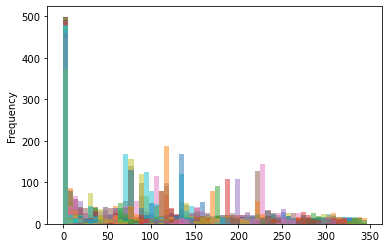

In [6]:
%%time
ax = df.plot.hist(bins=60, alpha=0.5, legend=False)
ax.plot()
plt.show()

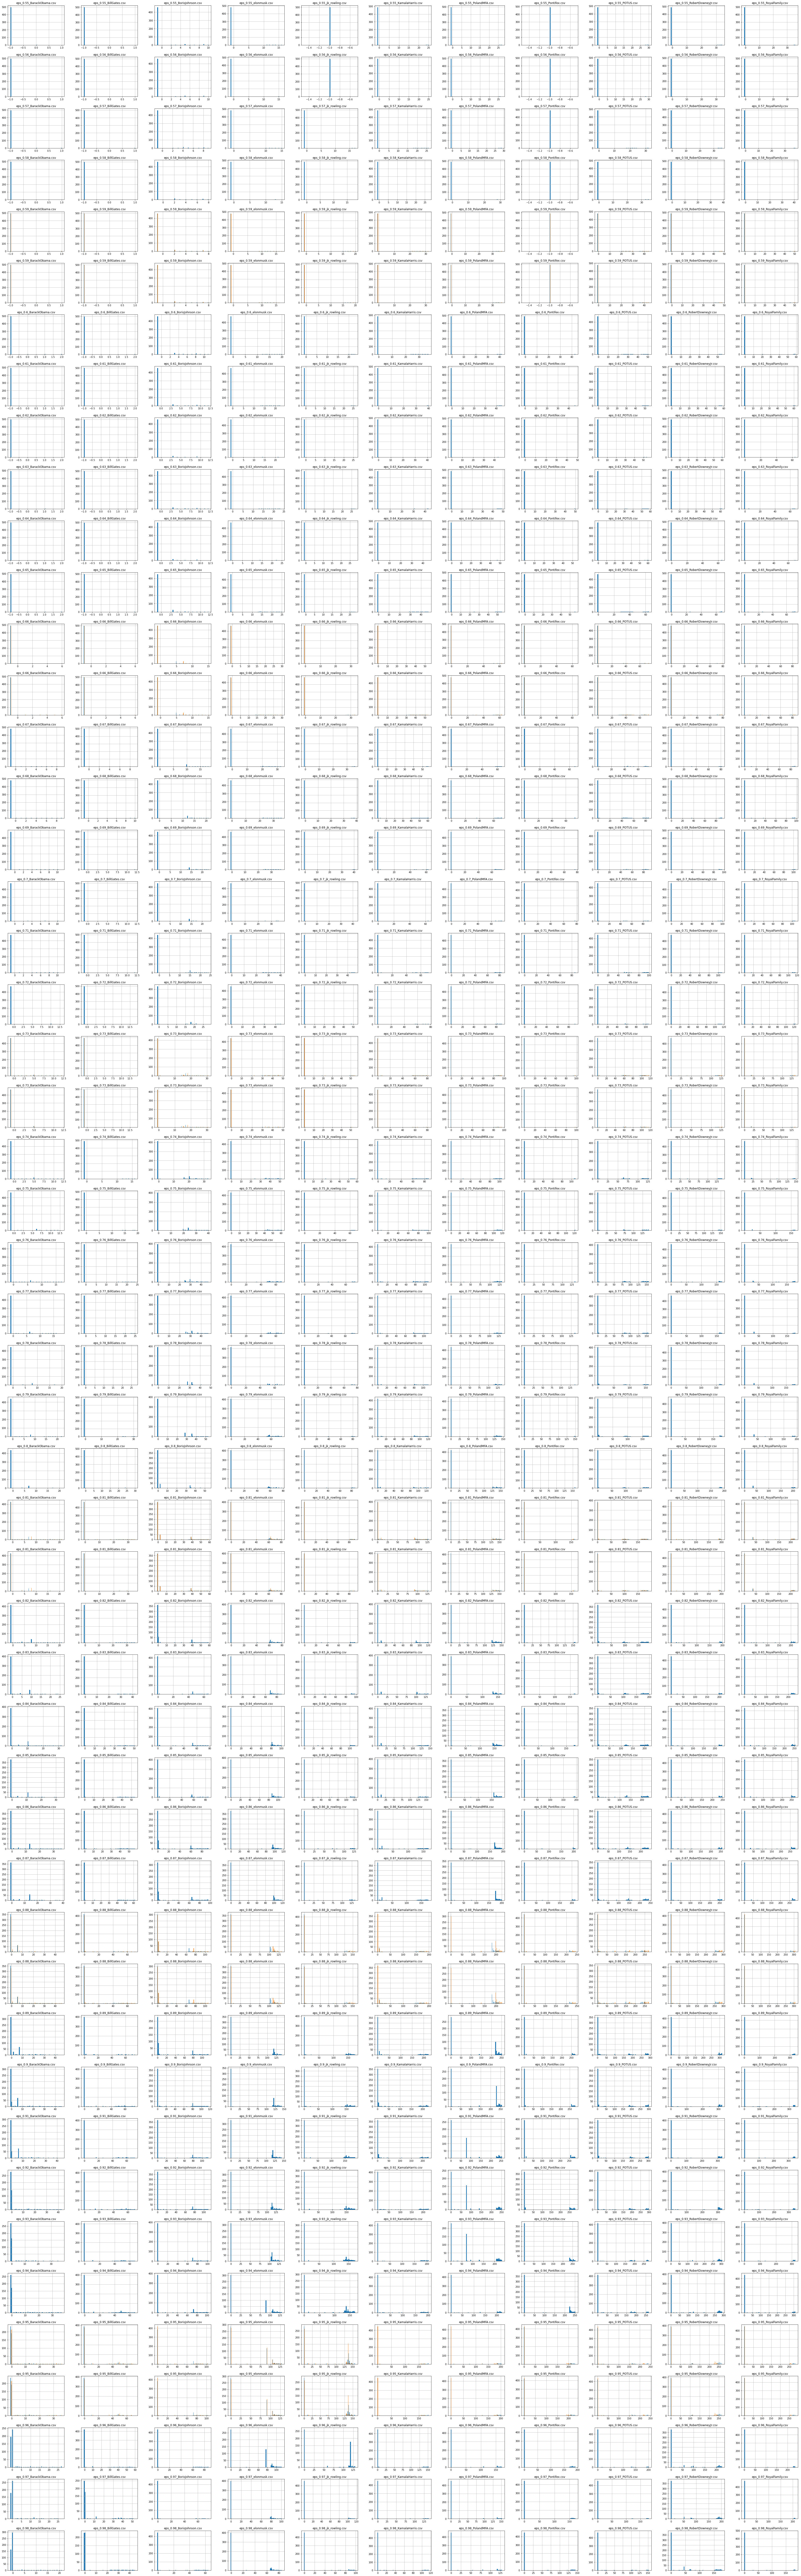

In [7]:
%%time
a = df.hist(bins=60, alpha=1, legend=False, figsize=(60,n*4), layout=(n,11))

### Clustering evaluation


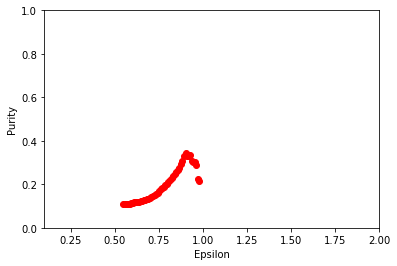

Max purity score is P=0.345, for epsilon=0.902. 


In [14]:
sc = get_purity_for_n_results(class_vector, results, len(results))
epsilons = get_epsilon_array(epsilon_start, epsilon_end, n)


plt.plot(epsilons, sc, 'ro')
plt.axis([0.1, 2, 0, 1])
plt.xlabel("Epsilon")
plt.ylabel("Purity")
plt.show()

max_purity=max(sc)
eps_for_max_purity=epsilons[sc.index(max_purity)]
print("Max purity score is P={}, for epsilon={}. ".format(round(max_purity,3), eps_for_max_purity))

In [9]:
def get_purity_for_n_results(class_vector, results, number):
    scores = []
    for i in range(number):
        scores.append(purity_score(class_vector, results[i]))

    return scores

In [ ]:
# df.hist(by=np.random.randint(0, 4, 1000), figsize=(6, 4));
# ax = df.plot(subplots=True, layout=(10,11), legend=False)
# ax.plot()
# plt.show()

# a = df.hist(bins=60, alpha=1, legend=False, figsize=(50,50), layout=(10,11))
# figure, ax = plt.subplots(nrows=1, ncols=11)
#
# for i in range(11):
#     ax[i] = df.iloc[:,i].plot.hist(bins=60, alpha=0.5, legend=False, figsize=(50,50), layout=(10,11))
# # ax.plot()
# # plt.show()
# figure.tight_layout()

In [ ]:
import numpy as np
# from sklearn import metrics
#
# def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    # contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # print(contingency_matrix)
    # return purity
    # return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [ ]:
# score = purity_score(class_vector, results[2])
# score

In [ ]:
# from sklearn.manifold import TSNE
# import numpy as np
# X_embedded = TSNE(n_components=2).fit_transform(tweet_vector)

In [ ]:
# print(len())
# len(results[0])

In [ ]:
# cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
# cax.get_xaxis().set_visible(False)
# cax.get_yaxis().set_visible(False)
# cax.patch.set_alpha(0)
# cax.set_frame_on(False)
# plt.colorbar(orientation='vertical')
# plt.show()